# Scania Component X: Predictive Maintanance

Complete Scania Component X Predictive Maintenance Pipeline
This notebook provides a complete, executable workflow from data loading to model evaluation.

## Import Libraries

In [9]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

## Data Preprocessing

### Data Loading

In [10]:
# print("=" * 80)
# print("SECTION 1: LOADING DATA")
# print("=" * 80)

datapath = "/content/drive/MyDrive/MA6514/data"

# Load training data
train_data = pd.read_csv(os.path.join(datapath, "train_operational_readouts.csv"))
train_data_y = pd.read_csv(os.path.join(datapath, "train_tte.csv"))
vehicle_data = pd.read_csv(os.path.join(datapath, "train_specifications.csv"))

# Load validation data
validation_data = pd.read_csv(os.path.join(datapath, "validation_operational_readouts.csv"))
validation_data_y = pd.read_csv(os.path.join(datapath, "validation_labels.csv"))
validation_vehicle_data = pd.read_csv(os.path.join(datapath, "validation_specifications.csv"))

# Load test data
test_data = pd.read_csv(os.path.join(datapath, "test_operational_readouts.csv"))
test_data_y = pd.read_csv(os.path.join(datapath, "test_labels.csv"))
test_vehicle_data = pd.read_csv(os.path.join(datapath, "test_specifications.csv"))

print(f"✓ Training data loaded: {train_data.shape}")
print(f"✓ Validation data loaded: {validation_data.shape}")
print(f"✓ Test data loaded: {test_data.shape}")

✓ Training data loaded: (1122452, 107)
✓ Validation data loaded: (196227, 107)
✓ Test data loaded: (198140, 107)


### Data Merging

In [11]:
# print("\n" + "=" * 80)
# print("SECTION 2: MERGING DATASETS")
# print("=" * 80)

train_data = (train_data
      .merge(train_data_y, on="vehicle_id", how="left")
      .merge(vehicle_data, on="vehicle_id", how="left")
      .sort_values(["vehicle_id","time_step"])
      .reset_index(drop=True))

validation_data = (validation_data
      .merge(validation_data_y, on="vehicle_id", how="left")
      .merge(validation_vehicle_data, on="vehicle_id", how="left")
      .sort_values(["vehicle_id","time_step"])
      .reset_index(drop=True))

test_data = (test_data
      .merge(test_data_y, on="vehicle_id", how="left")
      .merge(test_vehicle_data, on="vehicle_id", how="left")
      .sort_values(["vehicle_id","time_step"])
      .reset_index(drop=True))

print("✓ Data merged successfully")

✓ Data merged successfully


### Identify Columns

In [12]:
# print("\n" + "=" * 80)
# print("SECTION 3: IDENTIFYING COLUMN TYPES")
# print("=" * 80)

id_cols = ['vehicle_id', 'time_step']
spec_cols = [col for col in vehicle_data.columns if col != 'vehicle_id']
original_train_target_cols = [col for col in train_data_y.columns if col != 'vehicle_id']
label_col_name = [col for col in validation_data_y.columns if col != 'vehicle_id'][0]

known_non_sensor_cols = set(id_cols + spec_cols + original_train_target_cols + [label_col_name])
sensor_cols = [col for col in train_data.columns if col not in known_non_sensor_cols]

print(f"✓ Identified {len(sensor_cols)} sensor columns")
print(f"✓ Identified {len(spec_cols)} specification columns")
print(f"✓ Sensor columns: {sensor_cols[:5]}... (showing first 5)")

✓ Identified 105 sensor columns
✓ Identified 8 specification columns
✓ Sensor columns: ['171_0', '666_0', '427_0', '837_0', '167_0']... (showing first 5)


### Missing Value Handling

In [13]:
# print("\n" + "=" * 80)
# print("SECTION 4: HANDLING MISSING VALUES")
# print("=" * 80)

def fill_missing_values(df, sensor_cols):
    """Fill missing values using forward-fill, backward-fill, and zero fill."""
    df[sensor_cols] = df.groupby('vehicle_id')[sensor_cols].ffill()
    df[sensor_cols] = df.groupby('vehicle_id')[sensor_cols].bfill()
    df[sensor_cols] = df[sensor_cols].fillna(0)
    return df

train_data = fill_missing_values(train_data, sensor_cols)
validation_data = fill_missing_values(validation_data, sensor_cols)
test_data = fill_missing_values(test_data, sensor_cols)

print(f"✓ Remaining NaNs in train: {train_data[sensor_cols].isna().sum().sum()}")
print(f"✓ Remaining NaNs in validation: {validation_data[sensor_cols].isna().sum().sum()}")
print(f"✓ Remaining NaNs in test: {test_data[sensor_cols].isna().sum().sum()}")

✓ Remaining NaNs in train: 0
✓ Remaining NaNs in validation: 0
✓ Remaining NaNs in test: 0


### Feature Engineering - Aggregated Features

In [14]:
# print("\n" + "=" * 80)
# print("SECTION 5: CREATING AGGREGATED FEATURES")
# print("=" * 80)

def create_aggregated_features(df, sensor_cols, spec_cols):
    """
    Aggregate time series into statistical features per vehicle.
    This converts each vehicle's time series into a single feature vector.
    """
    # Aggregate sensor data
    agg_dict = {}
    for col in sensor_cols:
        agg_dict[col] = ['mean', 'std', 'min', 'max', 'last']

    agg_features = df.groupby('vehicle_id')[sensor_cols].agg(agg_dict)
    agg_features.columns = ['_'.join(col).strip() for col in agg_features.columns.values]

    # Add time-based features
    time_features = df.groupby('vehicle_id').agg({
        'time_step': ['min', 'max', 'count']
    })
    time_features.columns = ['time_step_min', 'time_step_max', 'num_observations']

    # Add specifications
    spec_features = df.groupby('vehicle_id')[spec_cols].first()

    # Combine all features
    final_features = pd.concat([agg_features, time_features, spec_features], axis=1)

    # Get labels
    if 'class_label' in df.columns:
        labels = df.groupby('vehicle_id')['class_label'].first()
    else:
        labels = df.groupby('vehicle_id')['in_study_repair'].first()

    return final_features, labels

# Create aggregated features for all datasets
X_train_agg, y_train_agg = create_aggregated_features(train_data, sensor_cols, spec_cols)
X_val_agg, y_val_agg = create_aggregated_features(validation_data, sensor_cols, spec_cols)
X_test_agg, y_test_agg = create_aggregated_features(test_data, sensor_cols, spec_cols)

print(f"✓ Train aggregated features shape: {X_train_agg.shape}")
print(f"✓ Validation aggregated features shape: {X_val_agg.shape}")
print(f"✓ Test aggregated features shape: {X_test_agg.shape}")
print(f"\n✓ Train label distribution:\n{y_train_agg.value_counts()}")
print(f"\n✓ Validation label distribution:\n{y_val_agg.value_counts()}")

✓ Train aggregated features shape: (23550, 536)
✓ Validation aggregated features shape: (5046, 536)
✓ Test aggregated features shape: (5045, 536)

✓ Train label distribution:
in_study_repair
0    21278
1     2272
Name: count, dtype: int64

✓ Validation label distribution:
class_label
0    4910
4      76
3      30
1      16
2      14
Name: count, dtype: int64


### Encode Categotical Features

In [15]:
# print("\n" + "=" * 80)
# print("SECTION 6: ENCODING CATEGORICAL FEATURES")
# print("=" * 80)

def safe_label_encode(train_df, val_df, test_df, columns):
    """
    Safely encode categorical columns, handling unseen categories in val/test.
    Unseen categories are mapped to a special 'unknown' value.
    """
    label_encoders = {}

    for col in columns:
        # Get all unique values from all datasets
        all_categories = set(
            train_df[col].astype(str).unique().tolist() +
            val_df[col].astype(str).unique().tolist() +
            test_df[col].astype(str).unique().tolist()
        )

        le = LabelEncoder()
        # Fit on all possible categories
        le.fit(list(all_categories))

        # Transform all datasets
        train_df[col] = le.transform(train_df[col].astype(str))
        val_df[col] = le.transform(val_df[col].astype(str))
        test_df[col] = le.transform(test_df[col].astype(str))

        label_encoders[col] = le

    return train_df, val_df, test_df, label_encoders

# Encode specification columns safely
X_train_agg, X_val_agg, X_test_agg, label_encoders = safe_label_encode(
    X_train_agg, X_val_agg, X_test_agg, spec_cols
)

print(f"✓ Encoded {len(spec_cols)} categorical features")
print(f"✓ Handled unseen categories in validation/test sets")


✓ Encoded 8 categorical features
✓ Handled unseen categories in validation/test sets


### Feature Scaling

In [16]:
# print("\n" + "=" * 80)
# print("SECTION 7: SCALING FEATURES")
# print("=" * 80)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_agg)
X_val_scaled = scaler.transform(X_val_agg)
X_test_scaled = scaler.transform(X_test_agg)

print(f"✓ Features scaled using StandardScaler")
print(f"✓ Train shape: {X_train_scaled.shape}")
print(f"✓ Validation shape: {X_val_scaled.shape}")
print(f"✓ Test shape: {X_test_scaled.shape}")

✓ Features scaled using StandardScaler
✓ Train shape: (23550, 536)
✓ Validation shape: (5046, 536)
✓ Test shape: (5045, 536)


### Custom Cost Function

In [17]:
# print("\n" + "=" * 80)
# print("SECTION 8: DEFINING CUSTOM COST FUNCTION")
# print("=" * 80)

def calculate_cost(y_true, y_pred):
    """
    Calculate custom cost based on Table 1 from the paper.
    False negatives are MUCH more expensive than false positives.
    """
    cost_matrix = {
        (0, 1): 7, (0, 2): 8, (0, 3): 9, (0, 4): 10,
        (1, 0): 200, (1, 2): 7, (1, 3): 8, (1, 4): 9,
        (2, 0): 300, (2, 1): 200, (2, 3): 7, (2, 4): 8,
        (3, 0): 400, (3, 1): 300, (3, 2): 200, (3, 4): 7,
        (4, 0): 500, (4, 1): 400, (4, 2): 300, (4, 3): 200
    }

    total_cost = 0
    for true_label, pred_label in zip(y_true, y_pred):
        if true_label != pred_label:
            total_cost += cost_matrix.get((true_label, pred_label), 0)

    return total_cost

print("✓ Custom cost function defined")
print("  - False negatives have costs: 200-500")
print("  - False positives have costs: 7-10")


✓ Custom cost function defined
  - False negatives have costs: 200-500
  - False positives have costs: 7-10


## Model Training

### Model 1 - Random Forest

In [18]:

# print("\n" + "=" * 80)
# print("SECTION 9: TRAINING RANDOM FOREST MODEL")
# print("=" * 80)

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

print("Training Random Forest (this may take a few minutes)...")
rf_model.fit(X_train_scaled, y_train_agg)
print("✓ Model trained")

# Predict on validation set
val_pred_rf = rf_model.predict(X_val_scaled)

print("\n--- Random Forest Results on Validation Set ---")
print(classification_report(y_val_agg, val_pred_rf, zero_division=0))
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_val_agg, val_pred_rf))
print(f"\nCustom Cost: {calculate_cost(y_val_agg, val_pred_rf)}")


Training Random Forest (this may take a few minutes)...
✓ Model trained

--- Random Forest Results on Validation Set ---
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      4910
           1       0.00      0.00      0.00        16
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00        30
           4       0.00      0.00      0.00        76

    accuracy                           0.97      5046
   macro avg       0.19      0.20      0.20      5046
weighted avg       0.95      0.97      0.96      5046


Confusion Matrix:
[[4910    0    0    0    0]
 [  16    0    0    0    0]
 [  14    0    0    0    0]
 [  30    0    0    0    0]
 [  76    0    0    0    0]]

Custom Cost: 57400


### Model 2 - XGBoost

In [19]:
# print("\n" + "=" * 80)
# print("SECTION 10: TRAINING XGBOOST MODEL")
# print("=" * 80)

xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.1,
    random_state=42,
    eval_metric='mlogloss',
    use_label_encoder=False
)

print("Training XGBoost (this may take a few minutes)...")
xgb_model.fit(X_train_scaled, y_train_agg)
print("✓ Model trained")

# Predict on validation set
val_pred_xgb = xgb_model.predict(X_val_scaled)

print("\n--- XGBoost Results on Validation Set ---")
print(classification_report(y_val_agg, val_pred_xgb, zero_division=0))
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_val_agg, val_pred_xgb))
print(f"\nCustom Cost: {calculate_cost(y_val_agg, val_pred_xgb)}")

Training XGBoost (this may take a few minutes)...
✓ Model trained

--- XGBoost Results on Validation Set ---
              precision    recall  f1-score   support

           0       0.98      0.84      0.90      4910
           1       0.00      0.25      0.01        16
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00        30
           4       0.00      0.00      0.00        76

    accuracy                           0.82      5046
   macro avg       0.20      0.22      0.18      5046
weighted avg       0.95      0.82      0.88      5046


Confusion Matrix:
[[4134  776    0    0    0]
 [  12    4    0    0    0]
 [  10    4    0    0    0]
 [  17   13    0    0    0]
 [  55   21    0    0    0]]

Custom Cost: 58232


## Test Set Evaluation

In [20]:
# print("\n" + "=" * 80)
# print("SECTION 11: EVALUATING ON TEST SET")
# print("=" * 80)

# Choose best model based on validation cost
rf_cost = calculate_cost(y_val_agg, val_pred_rf)
xgb_cost = calculate_cost(y_val_agg, val_pred_xgb)

if rf_cost < xgb_cost:
    best_model = rf_model
    best_model_name = "Random Forest"
    print(f"✓ Best model: Random Forest (validation cost: {rf_cost})")
else:
    best_model = xgb_model
    best_model_name = "XGBoost"
    print(f"✓ Best model: XGBoost (validation cost: {xgb_cost})")

# Predict on test set
test_pred = best_model.predict(X_test_scaled)

print(f"\n--- {best_model_name} Results on Test Set ---")
print(classification_report(y_test_agg, test_pred, zero_division=0))
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test_agg, test_pred))
print(f"\nCustom Cost: {calculate_cost(y_test_agg, test_pred)}")

✓ Best model: Random Forest (validation cost: 57400)

--- Random Forest Results on Test Set ---
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      4903
           1       0.05      0.04      0.04        26
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00        41
           4       0.00      0.00      0.00        60

    accuracy                           0.97      5045
   macro avg       0.20      0.21      0.21      5045
weighted avg       0.95      0.97      0.96      5045


Confusion Matrix:
[[4883   20    0    0    0]
 [  25    1    0    0    0]
 [  15    0    0    0    0]
 [  41    0    0    0    0]
 [  59    1    0    0    0]]

Custom Cost: 55940


## Feature Importance

In [21]:
# print("\n" + "=" * 80)
# print("SECTION 12: FEATURE IMPORTANCE ANALYSIS")
# print("=" * 80)

# Get feature importance
if best_model_name == "Random Forest":
    importances = best_model.feature_importances_
else:
    importances = best_model.feature_importances_

# Create dataframe
feature_importance_df = pd.DataFrame({
    'feature': X_train_agg.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance_df.head(20).to_string(index=False))


Top 20 Most Important Features:
         feature  importance
   time_step_max    0.028167
      158_9_last    0.006589
       158_9_max    0.006005
      158_9_mean    0.005693
       167_6_std    0.005325
       158_9_std    0.005157
       167_1_max    0.004859
       666_0_max    0.004843
       397_0_std    0.004830
      167_1_mean    0.004716
       666_0_std    0.004543
      397_0_mean    0.004517
       167_1_std    0.004431
       167_6_max    0.004407
      167_1_last    0.004349
num_observations    0.004292
      397_0_last    0.004124
      397_6_mean    0.004085
      167_6_mean    0.004077
       397_0_max    0.004029


## Summary

In [22]:
# print("\n" + "=" * 80)
# print("PIPELINE COMPLETE - SUMMARY")
# print("=" * 80)
print(f"✓ Data loaded and preprocessed")
print(f"✓ {len(sensor_cols)} sensor features aggregated into {X_train_scaled.shape[1]} features")
print(f"✓ Two models trained: Random Forest and XGBoost")
print(f"✓ Best model: {best_model_name}")
print(f"\nFinal Results:")
print(f"  - Validation Cost: {min(rf_cost, xgb_cost)}")
print(f"  - Test Cost: {calculate_cost(y_test_agg, test_pred)}")
print("\n" + "=" * 80)

✓ Data loaded and preprocessed
✓ 105 sensor features aggregated into 536 features
✓ Two models trained: Random Forest and XGBoost
✓ Best model: Random Forest

Final Results:
  - Validation Cost: 57400
  - Test Cost: 55940



## Optional: LSTM Time Series Model

In [23]:
# """
# OPTIONAL EXTENSION: LSTM Model for Time Series
# Run this AFTER the main pipeline if you want to try deep learning.
# This requires TensorFlow and more computation time.
# """

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from sklearn.utils.class_weight import compute_class_weight

# print("=" * 80)
# print("OPTIONAL: LSTM TIME SERIES MODEL")
# print("=" * 80)

# # ============================================================================
# # PREPARE SEQUENCES
# # ============================================================================
# def prepare_sequences(df, sensor_cols, sequence_length=20):
#     """
#     Create fixed-length sequences for each vehicle.
#     Uses the last 'sequence_length' time steps.
#     """
#     sequences = []
#     labels = []
#     vehicle_ids = []

#     for vehicle_id in df['vehicle_id'].unique():
#         vehicle_df = df[df['vehicle_id'] == vehicle_id].sort_values('time_step')

#         # Get sensor data
#         sensor_data = vehicle_df[sensor_cols].values

#         # Get label
#         if 'class_label' in vehicle_df.columns:
#             label = vehicle_df['class_label'].iloc[-1]
#         else:
#             label = vehicle_df['in_study_repair'].iloc[-1]

#         # Take last sequence_length time steps (pad if necessary)
#         if len(sensor_data) >= sequence_length:
#             sequence = sensor_data[-sequence_length:]
#         else:
#             # Pad with zeros at the beginning
#             padding = np.zeros((sequence_length - len(sensor_data), len(sensor_cols)))
#             sequence = np.vstack([padding, sensor_data])

#         sequences.append(sequence)
#         labels.append(label)
#         vehicle_ids.append(vehicle_id)

#     return np.array(sequences), np.array(labels), np.array(vehicle_ids)

# print("Preparing sequences...")
# sequence_length = 20

# X_train_seq, y_train_seq, train_ids = prepare_sequences(
#     train_data, sensor_cols, sequence_length
# )
# X_val_seq, y_val_seq, val_ids = prepare_sequences(
#     validation_data, sensor_cols, sequence_length
# )
# X_test_seq, y_test_seq, test_ids = prepare_sequences(
#     test_data, sensor_cols, sequence_length
# )

# print(f"✓ Train sequences: {X_train_seq.shape}")
# print(f"✓ Val sequences: {X_val_seq.shape}")
# print(f"✓ Test sequences: {X_test_seq.shape}")

# # ============================================================================
# # NORMALIZE SEQUENCES
# # ============================================================================
# print("\nNormalizing sequences...")
# seq_scaler = StandardScaler()

# # Reshape for scaling
# X_train_seq_2d = X_train_seq.reshape(-1, X_train_seq.shape[-1])
# seq_scaler.fit(X_train_seq_2d)
# X_train_seq_norm = seq_scaler.transform(X_train_seq_2d).reshape(X_train_seq.shape)

# X_val_seq_2d = X_val_seq.reshape(-1, X_val_seq.shape[-1])
# X_val_seq_norm = seq_scaler.transform(X_val_seq_2d).reshape(X_val_seq.shape)

# X_test_seq_2d = X_test_seq.reshape(-1, X_test_seq.shape[-1])
# X_test_seq_norm = seq_scaler.transform(X_test_seq_2d).reshape(X_test_seq.shape)

# print("✓ Sequences normalized")

# # ============================================================================
# # BUILD LSTM MODEL
# # ============================================================================
# def build_lstm_model(sequence_length, n_features, n_classes):
#     """Build LSTM model for sequence classification."""
#     model = keras.Sequential([
#         layers.LSTM(128, return_sequences=True,
#                    input_shape=(sequence_length, n_features)),
#         layers.Dropout(0.3),
#         layers.LSTM(64, return_sequences=False),
#         layers.Dropout(0.3),
#         layers.Dense(32, activation='relu'),
#         layers.Dropout(0.2),
#         layers.Dense(n_classes, activation='softmax' if n_classes > 2 else 'sigmoid')
#     ])

#     model.compile(
#         optimizer=keras.optimizers.Adam(learning_rate=0.001),
#         loss='sparse_categorical_crossentropy' if n_classes > 2 else 'binary_crossentropy',
#         metrics=['accuracy']
#     )

#     return model

# # Determine number of classes
# n_classes = len(np.unique(y_train_seq))
# print(f"\nBuilding LSTM model for {n_classes} classes...")

# lstm_model = build_lstm_model(
#     sequence_length=sequence_length,
#     n_features=len(sensor_cols),
#     n_classes=n_classes
# )

# print("✓ Model built")
# lstm_model.summary()

# # ============================================================================
# # HANDLE CLASS IMBALANCE
# # ============================================================================
# print("\nCalculating class weights...")
# class_weights = compute_class_weight(
#     'balanced',
#     classes=np.unique(y_train_seq),
#     y=y_train_seq
# )
# class_weight_dict = dict(enumerate(class_weights))
# print(f"✓ Class weights: {class_weight_dict}")

# # ============================================================================
# # TRAIN MODEL
# # ============================================================================
# print("\nTraining LSTM (this will take 10-20 minutes)...")

# history = lstm_model.fit(
#     X_train_seq_norm, y_train_seq,
#     validation_data=(X_val_seq_norm, y_val_seq),
#     epochs=50,
#     batch_size=32,
#     class_weight=class_weight_dict,
#     callbacks=[
#         keras.callbacks.EarlyStopping(
#             patience=10,
#             restore_best_weights=True,
#             monitor='val_loss'
#         ),
#         keras.callbacks.ReduceLROnPlateau(
#             patience=5,
#             factor=0.5,
#             monitor='val_loss'
#         )
#     ],
#     verbose=1
# )

# print("✓ Training complete")

# # ============================================================================
# # EVALUATE
# # ============================================================================
# print("\n--- LSTM Results on Validation Set ---")
# val_pred_lstm = lstm_model.predict(X_val_seq_norm)
# val_pred_lstm_classes = np.argmax(val_pred_lstm, axis=1) if n_classes > 2 else (val_pred_lstm > 0.5).astype(int).flatten()

# print(classification_report(y_val_seq, val_pred_lstm_classes, zero_division=0))
# print(f"\nConfusion Matrix:")
# print(confusion_matrix(y_val_seq, val_pred_lstm_classes))
# print(f"\nCustom Cost: {calculate_cost(y_val_seq, val_pred_lstm_classes)}")

# # Test set
# print("\n--- LSTM Results on Test Set ---")
# test_pred_lstm = lstm_model.predict(X_test_seq_norm)
# test_pred_lstm_classes = np.argmax(test_pred_lstm, axis=1) if n_classes > 2 else (test_pred_lstm > 0.5).astype(int).flatten()

# print(classification_report(y_test_seq, test_pred_lstm_classes, zero_division=0))
# print(f"\nConfusion Matrix:")
# print(confusion_matrix(y_test_seq, test_pred_lstm_classes))
# print(f"\nCustom Cost: {calculate_cost(y_test_seq, test_pred_lstm_classes)}")

# print("\n" + "=" * 80)
# print("LSTM MODEL COMPLETE")
# print("=" * 80)

## Model Evaluation

### Evaluation Function

In [24]:
import pandas as pd
import numpy as np

# print("\n" + "=" * 80)
# print("SECTION 13: PREDICTIVE MAINTENANCE SYSTEM")
# print("=" * 80)

def predict_maintenance_needs(model, vehicle_data, sensor_cols, spec_cols, scaler, label_encoders):

    # Create aggregated features (same as training)
    agg_dict = {}
    for col in sensor_cols:
        agg_dict[col] = ['mean', 'std', 'min', 'max', 'last']

    agg_features = vehicle_data.groupby('vehicle_id')[sensor_cols].agg(agg_dict)
    agg_features.columns = ['_'.join(col).strip() for col in agg_features.columns.values]

    # Add time-based features
    time_features = vehicle_data.groupby('vehicle_id').agg({
        'time_step': ['min', 'max', 'count']
    })
    time_features.columns = ['time_step_min', 'time_step_max', 'num_observations']

    # Add specifications
    spec_features = vehicle_data.groupby('vehicle_id')[spec_cols].first()

    # Combine
    final_features = pd.concat([agg_features, time_features, spec_features], axis=1)

    # Encode categorical features
    for col in spec_cols:
        all_cats = set(final_features[col].astype(str).unique().tolist())
        if col in label_encoders:
            le = label_encoders[col]
            # Add new categories if needed
            existing_cats = set(le.classes_)
            new_cats = all_cats - existing_cats
            if new_cats:
                le.classes_ = np.concatenate([le.classes_, list(new_cats)])
        final_features[col] = label_encoders[col].transform(final_features[col].astype(str))

    # Scale features
    X_scaled = scaler.transform(final_features)

    # Predict
    predictions = model.predict(X_scaled)
    probabilities = model.predict_proba(X_scaled)

    # Create results dataframe
    results = pd.DataFrame({
        'vehicle_id': final_features.index,
        'predicted_class': predictions,
        'current_time_step': time_features['time_step_max'].values,
        'total_observations': time_features['num_observations'].values
    })

    # Add probability for each class
    n_classes = probabilities.shape[1]
    for i in range(n_classes):
        results[f'prob_class_{i}'] = probabilities[:, i]

    # Calculate prediction confidence (max probability)
    prob_cols = [f'prob_class_{i}' for i in range(n_classes)]
    results['prediction_confidence'] = results[prob_cols].max(axis=1)

    # Handle both binary (2 classes) and multi-class (5 classes) scenarios
    if n_classes == 2:
        # Binary classification: 0 = healthy, 1 = needs maintenance
        results['risk_level'] = results['predicted_class'].map({
            0: 'LOW - Component healthy, no action needed',
            1: 'HIGH - Component failure predicted, schedule maintenance'
        })
        # Calculate urgency score for binary
        results['urgency_score'] = results['prob_class_1'] * 5  # Higher prob of failure = more urgent

        # Recommendations for binary
        def get_recommendation_binary(row):
            if row['predicted_class'] == 0:
                return "Continue normal operation. Component is healthy."
            else:
                prob = row['prob_class_1']
                if prob >= 0.8:
                    return " URGENT: High probability of failure. Schedule immediate maintenance."
                elif prob >= 0.6:
                    return " WARNING: Moderate probability of failure. Schedule maintenance soon."
                else:
                    return " ATTENTION: Component may need maintenance. Monitor closely."

        results['recommendation'] = results.apply(get_recommendation_binary, axis=1)

    else:
        # Multi-class classification (5 classes)
        results['risk_level'] = results['predicted_class'].map({
            0: 'LOW - No action needed',
            1: 'MEDIUM - Schedule within 48 time_steps',
            2: 'HIGH - Schedule within 24 time_steps',
            3: 'URGENT - Schedule within 12 time_steps',
            4: 'CRITICAL - Schedule within 6 time_steps'
        })
        # Calculate urgency score for multi-class
        urgency_weights = [1, 2, 3, 4, 5]
        results['urgency_score'] = sum(
            results[f'prob_class_{i}'] * urgency_weights[i]
            for i in range(min(5, n_classes))
        )

        # Recommendations for multi-class
        def get_recommendation_multiclass(row):
            if row['predicted_class'] == 0:
                return "Continue normal operation. Next check in 48+ time_steps."
            elif row['predicted_class'] == 1:
                return "Schedule maintenance within 24-48 time_steps."
            elif row['predicted_class'] == 2:
                return "Schedule maintenance within 12-24 time_steps."
            elif row['predicted_class'] == 3:
                return "Schedule maintenance within 6-12 time_steps."
            else:  # class 4
                return "URGENT: Schedule immediate maintenance (0-6 time_steps)."

        results['recommendation'] = results.apply(get_recommendation_multiclass, axis=1)

    return results.sort_values('urgency_score', ascending=False)

### Predict on Validation Set

In [25]:
print("\n--- Making Predictions on Validation Vehicles ---")
validation_predictions = predict_maintenance_needs(
    model=best_model,
    vehicle_data=validation_data,
    sensor_cols=sensor_cols,
    spec_cols=spec_cols,
    scaler=scaler,
    label_encoders=label_encoders
)

n_classes = len([col for col in validation_predictions.columns if col.startswith('prob_class_')])
print(f"\n✓ Model type: {'Binary (2 classes)' if n_classes == 2 else f'Multi-class ({n_classes} classes)'}")
print(f"✓ Predictions generated for {len(validation_predictions)} vehicles")

print("\n" + "=" * 80)
print("TOP 20 VEHICLES REQUIRING URGENT ATTENTION")
print("=" * 80)
print(validation_predictions[['vehicle_id', 'predicted_class', 'risk_level',
                               'urgency_score', 'prediction_confidence',
                               'recommendation']].head(20).to_string(index=False))


--- Making Predictions on Validation Vehicles ---

✓ Model type: Binary (2 classes)
✓ Predictions generated for 5046 vehicles

TOP 20 VEHICLES REQUIRING URGENT ATTENTION
 vehicle_id  predicted_class                                risk_level  urgency_score  prediction_confidence                                   recommendation
       1389                0 LOW - Component healthy, no action needed       2.236946               0.552611 Continue normal operation. Component is healthy.
       8229                0 LOW - Component healthy, no action needed       2.151177               0.569765 Continue normal operation. Component is healthy.
      14882                0 LOW - Component healthy, no action needed       2.107884               0.578423 Continue normal operation. Component is healthy.
      16725                0 LOW - Component healthy, no action needed       2.096237               0.580753 Continue normal operation. Component is healthy.
      15089                0 LOW - Comp

### Detailed Prediction Report

In [26]:
# print("\n" + "=" * 80)
# print("PREDICTION DISTRIBUTION")
# print("=" * 80)
print("\nNumber of vehicles by predicted class:")
print(validation_predictions['predicted_class'].value_counts().sort_index())
print("\nNumber of vehicles by risk level:")
print(validation_predictions['risk_level'].value_counts())

print("\n" + "=" * 80)
print("MAINTENANCE PRIORITY QUEUE")
print("=" * 80)

if n_classes == 2:
    # Binary classification
    high_risk_vehicles = validation_predictions[
        validation_predictions['predicted_class'] == 1
    ]
    print(f"\n HIGH RISK: {len(high_risk_vehicles)} vehicles predicted to need maintenance")
    if len(high_risk_vehicles) > 0:
        print("\nTop 10 by urgency:")
        print(high_risk_vehicles.head(10)[['vehicle_id', 'urgency_score',
                                 'prediction_confidence',
                                 'recommendation']].to_string(index=False))

    low_risk_vehicles = validation_predictions[
        validation_predictions['predicted_class'] == 0
    ]
    print(f"\n✓ LOW RISK: {len(low_risk_vehicles)} vehicles predicted to be healthy")

else:
    # Multi-class classification
    # Vehicles needing immediate attention (Class 3-4)
    urgent_vehicles = validation_predictions[
        validation_predictions['predicted_class'].isin([3, 4])
    ]
    print(f"\nCRITICAL/URGENT: {len(urgent_vehicles)} vehicles need immediate attention")
    if len(urgent_vehicles) > 0:
        print(urgent_vehicles[['vehicle_id', 'predicted_class', 'urgency_score',
                               'recommendation']].to_string(index=False))

    # Vehicles needing scheduled maintenance (Class 1-2)
    scheduled_vehicles = validation_predictions[
        validation_predictions['predicted_class'].isin([1, 2])
    ]
    print(f"\nSCHEDULED: {len(scheduled_vehicles)} vehicles need maintenance within 48 time_steps")
    if len(scheduled_vehicles) > 0:
        print(scheduled_vehicles.head(10)[['vehicle_id', 'predicted_class', 'recommendation']].to_string(index=False))


Number of vehicles by predicted class:
predicted_class
0    5046
Name: count, dtype: int64

Number of vehicles by risk level:
risk_level
LOW - Component healthy, no action needed    5046
Name: count, dtype: int64

MAINTENANCE PRIORITY QUEUE

 HIGH RISK: 0 vehicles predicted to need maintenance

✓ LOW RISK: 5046 vehicles predicted to be healthy


### Prediction Confidence Analysis

In [27]:
# print("\n" + "=" * 80)
# print("PREDICTION CONFIDENCE ANALYSIS")
# print("=" * 80)

print("\nPrediction Confidence Statistics:")
print(f"  Mean confidence: {validation_predictions['prediction_confidence'].mean():.3f}")
print(f"  Median confidence: {validation_predictions['prediction_confidence'].median():.3f}")
print(f"  Min confidence: {validation_predictions['prediction_confidence'].min():.3f}")
print(f"  Max confidence: {validation_predictions['prediction_confidence'].max():.3f}")

# Low confidence predictions that might need manual review
low_confidence = validation_predictions[
    validation_predictions['prediction_confidence'] < 0.6
]
print(f"\n{len(low_confidence)} predictions have confidence < 60% and may need manual review")
if len(low_confidence) > 0:
    print("\nLow confidence predictions:")
    print(low_confidence[['vehicle_id', 'predicted_class', 'prediction_confidence',
                          'recommendation']].head(10).to_string(index=False))


Prediction Confidence Statistics:
  Mean confidence: 0.833
  Median confidence: 0.838
  Min confidence: 0.553
  Max confidence: 0.991

⚠️ 6 predictions have confidence < 60% and may need manual review

Low confidence predictions:
 vehicle_id  predicted_class  prediction_confidence                                   recommendation
       1389                0               0.552611 Continue normal operation. Component is healthy.
       8229                0               0.569765 Continue normal operation. Component is healthy.
      14882                0               0.578423 Continue normal operation. Component is healthy.
      16725                0               0.580753 Continue normal operation. Component is healthy.
      15089                0               0.587331 Continue normal operation. Component is healthy.
       7441                0               0.588148 Continue normal operation. Component is healthy.


### Cost-Benefit Analysis

In [28]:
# print("\n" + "=" * 80)
# print("COST-BENEFIT ANALYSIS")
# print("=" * 80)

def calculate_maintenance_costs(predictions_df, n_classes):
    """Calculate expected costs based on maintenance strategy."""
    costs = {
        'preventive_maintenance': 0,
        'avoided_failures': 0,
    }

    # Cost per preventive maintenance
    PREVENTIVE_COST = 50
    # Cost of roadside failure
    FAILURE_COST = 500

    if n_classes == 2:
        # Binary: count predicted failures
        maintenance_needed = (predictions_df['predicted_class'] == 1).sum()
    else:
        # Multi-class: count all non-zero predictions
        maintenance_needed = (predictions_df['predicted_class'] > 0).sum()

    costs['preventive_maintenance'] = maintenance_needed * PREVENTIVE_COST
    costs['avoided_failures'] = maintenance_needed * FAILURE_COST
    costs['net_benefit'] = costs['avoided_failures'] - costs['preventive_maintenance']

    return costs, maintenance_needed

maintenance_costs, maintenance_count = calculate_maintenance_costs(
    validation_predictions, n_classes
)

print(f"\nMaintenance Strategy Analysis:")
print(f"  Vehicles flagged for maintenance: {maintenance_count}")
print(f"  Preventive maintenance cost: ${maintenance_costs['preventive_maintenance']:,.0f}")
print(f"  Avoided failure costs (estimated): ${maintenance_costs['avoided_failures']:,.0f}")
print(f"  Net benefit: ${maintenance_costs['net_benefit']:,.0f}")
print(f"  ROI: {(maintenance_costs['net_benefit'] / maintenance_costs['preventive_maintenance'] * 100) if maintenance_costs['preventive_maintenance'] > 0 else 0:.1f}%")


Maintenance Strategy Analysis:
  Vehicles flagged for maintenance: 0
  Preventive maintenance cost: $0
  Avoided failure costs (estimated): $0
  Net benefit: $0
  ROI: 0.0%


### Export Predictions

In [29]:
# print("\n" + "=" * 80)
# print("EXPORTING RESULTS")
# print("=" * 80)

# Save predictions to CSV
output_file = "maintenance_predictions.csv"
validation_predictions.to_csv(output_file, index=False)
print(f"✓ Predictions saved to: {output_file}")

# Create summary report
if n_classes == 2:
    summary = {
        'total_vehicles': len(validation_predictions),
        'high_risk': len(validation_predictions[validation_predictions['predicted_class'] == 1]),
        'low_risk': len(validation_predictions[validation_predictions['predicted_class'] == 0]),
        'avg_urgency_score': validation_predictions['urgency_score'].mean(),
        'avg_confidence': validation_predictions['prediction_confidence'].mean(),
        'maintenance_needed': maintenance_count
    }
else:
    summary = {
        'total_vehicles': len(validation_predictions),
        'critical': len(validation_predictions[validation_predictions['predicted_class'] == 4]),
        'urgent': len(validation_predictions[validation_predictions['predicted_class'] == 3]),
        'high_risk': len(validation_predictions[validation_predictions['predicted_class'] == 2]),
        'medium_risk': len(validation_predictions[validation_predictions['predicted_class'] == 1]),
        'low_risk': len(validation_predictions[validation_predictions['predicted_class'] == 0]),
        'avg_urgency_score': validation_predictions['urgency_score'].mean(),
        'avg_confidence': validation_predictions['prediction_confidence'].mean(),
        'maintenance_needed': maintenance_count
    }

summary_df = pd.DataFrame([summary])
summary_df.to_csv("maintenance_summary.csv", index=False)
print(f"✓ Summary saved to: maintenance_summary.csv")

print("\n" + "=" * 80)
print("PREDICTIVE MAINTENANCE SYSTEM COMPLETE")
print("=" * 80)
print(f"\n✓ System Type: {'Binary Classification' if n_classes == 2 else 'Multi-class Classification'}")
print(f"✓ Total Vehicles Analyzed: {len(validation_predictions)}")
print(f"✓ Vehicles Requiring Maintenance: {maintenance_count}")
print(f"✓ Average Prediction Confidence: {validation_predictions['prediction_confidence'].mean():.1%}")
print(f"✓ Files exported: maintenance_predictions.csv, maintenance_summary.csv")
print("\n✓ Ready for deployment!")
print("=" * 80)

✓ Predictions saved to: maintenance_predictions.csv
✓ Summary saved to: maintenance_summary.csv

PREDICTIVE MAINTENANCE SYSTEM COMPLETE

✓ System Type: Binary Classification
✓ Total Vehicles Analyzed: 5046
✓ Vehicles Requiring Maintenance: 0
✓ Average Prediction Confidence: 83.3%
✓ Files exported: maintenance_predictions.csv, maintenance_summary.csv

✓ Ready for deployment!


## Data Visualization

CREATING VISUALIZATIONS FOR PAPER

[1/10] Creating data overview visualization...
✓ Saved: figure1_data_overview.png


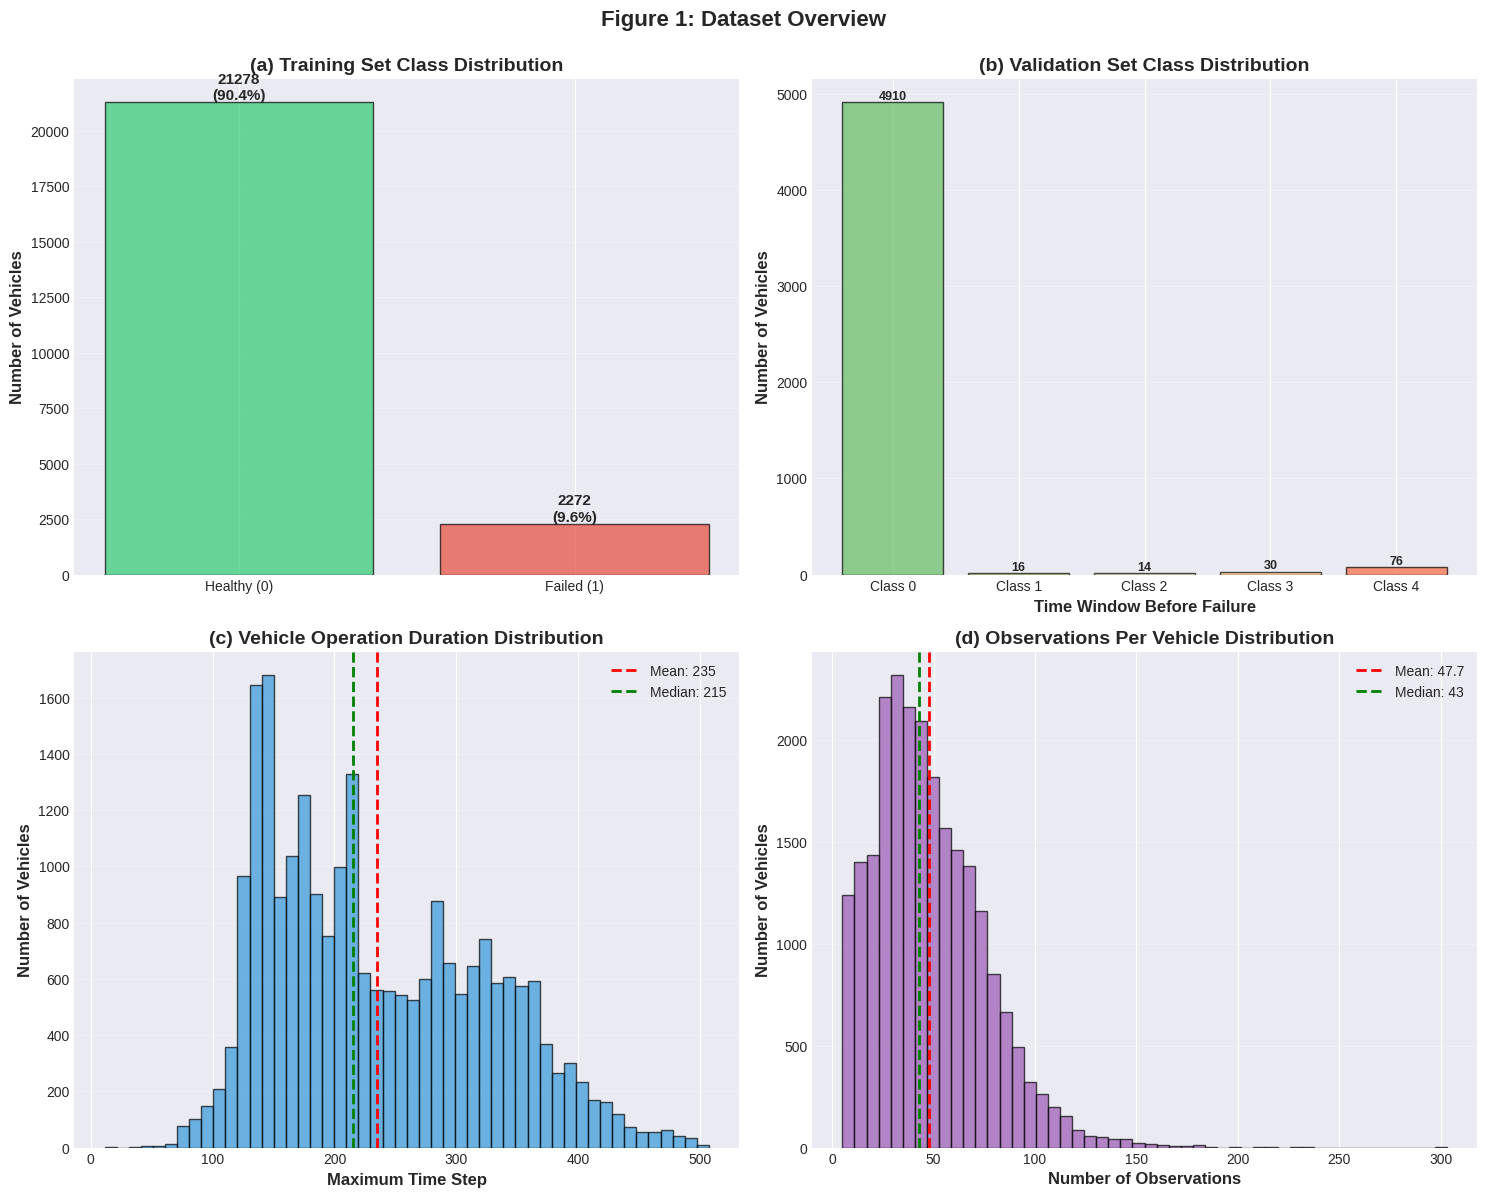


[2/10] Creating feature correlation heatmap...
✓ Saved: figure2_correlation_heatmap.png


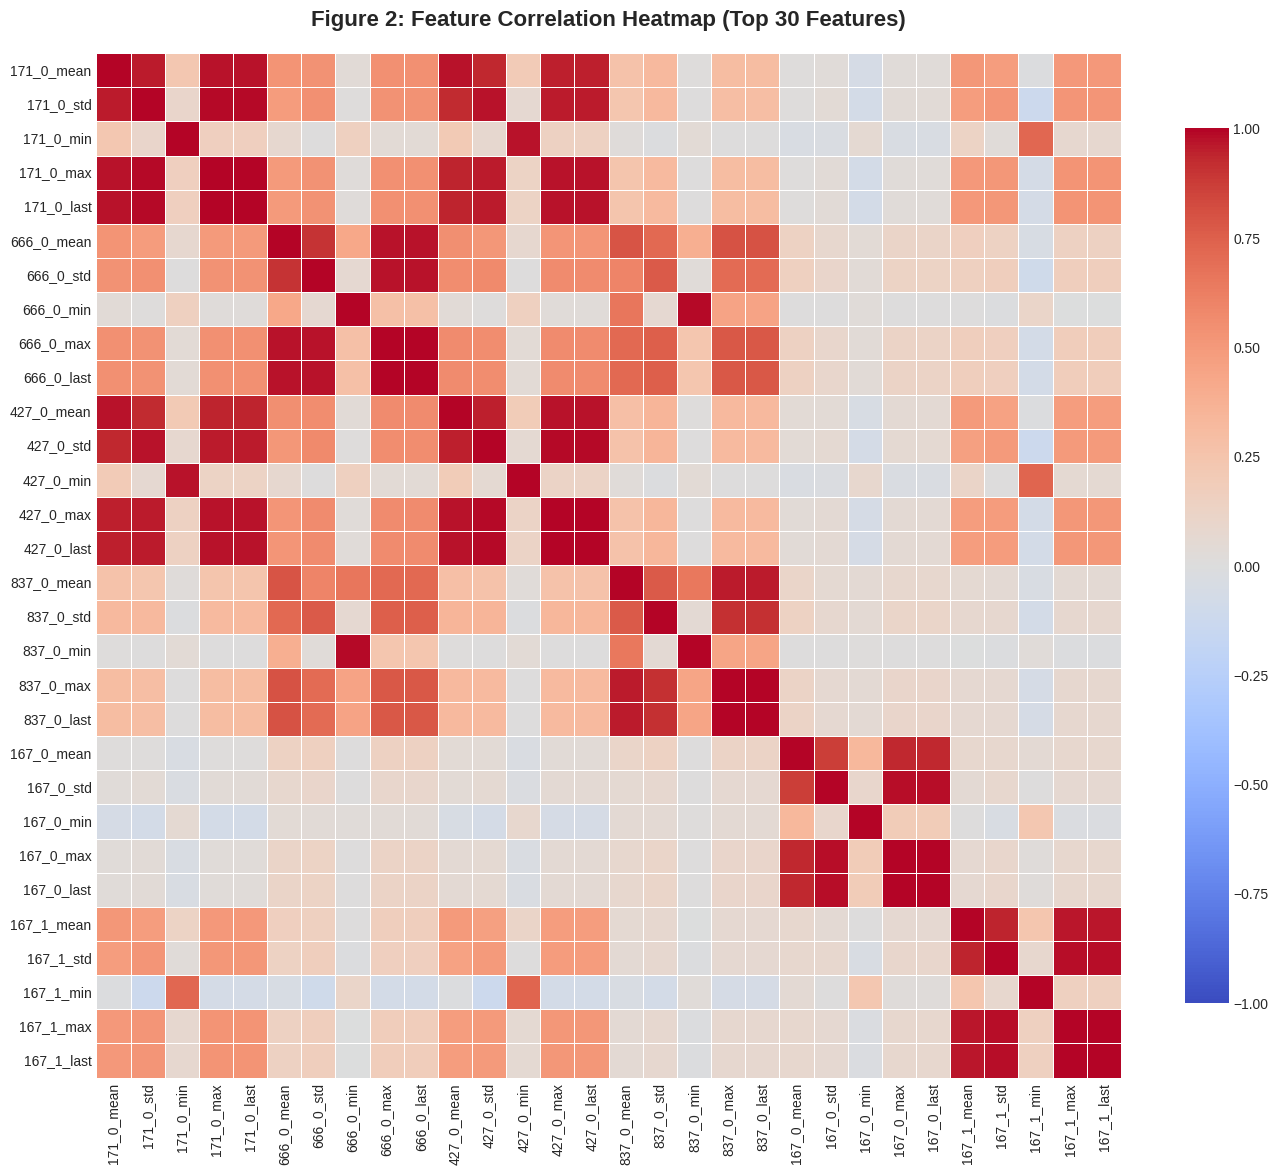


[3/10] Creating feature importance plot...
✓ Saved: figure3_feature_importance.png


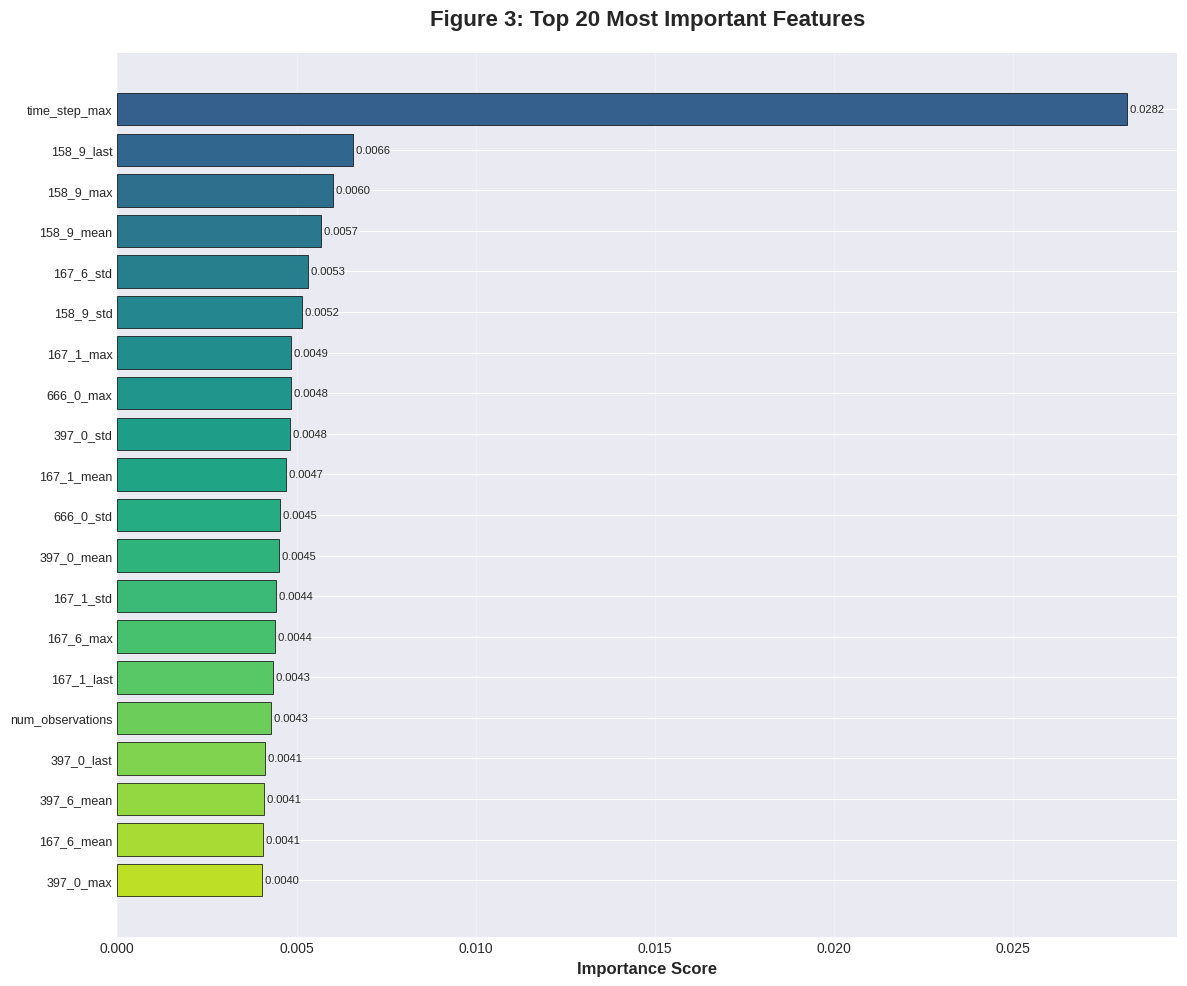


[4/10] Creating confusion matrices...
✓ Saved: figure4_confusion_matrices.png


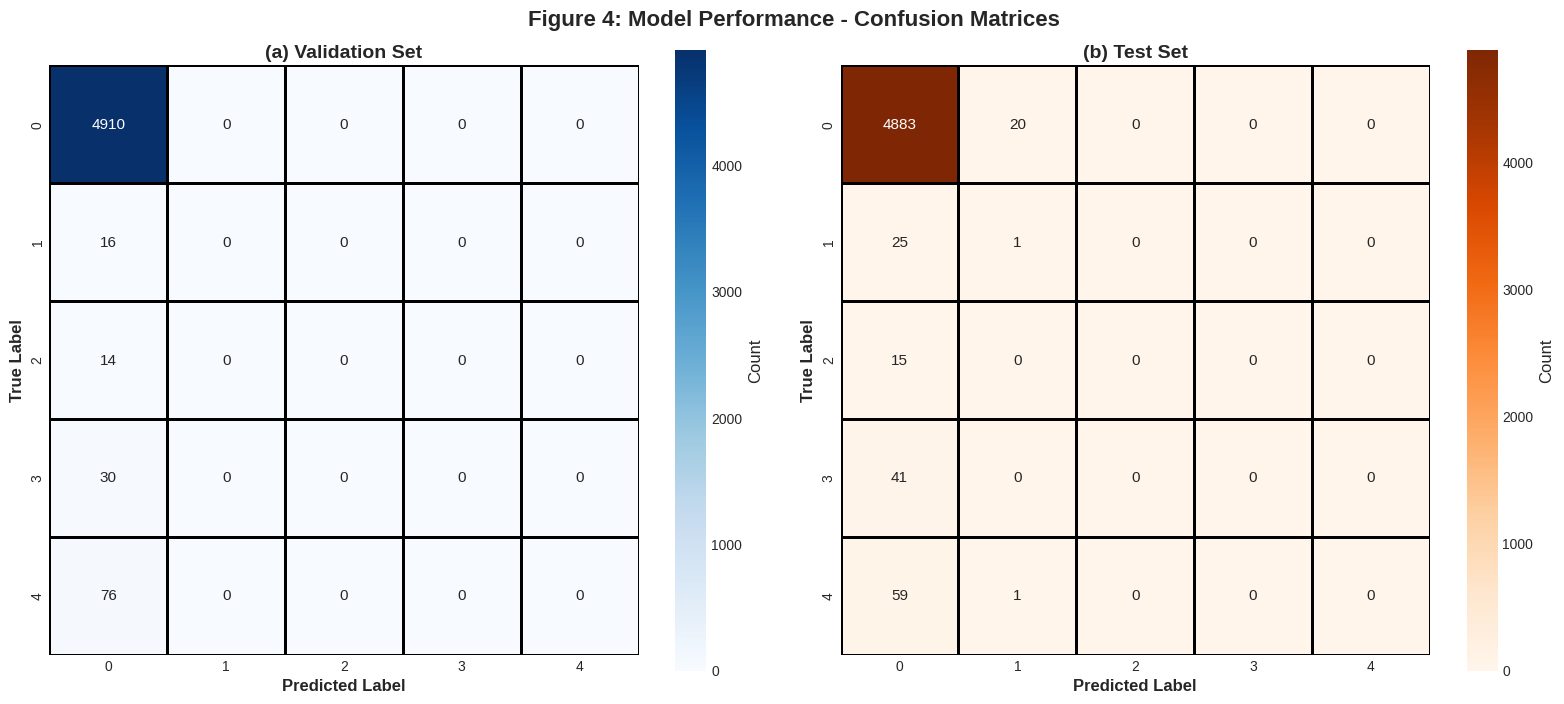


[5/10] Creating ROC curves...
✓ Saved: figure5_roc_curves.png


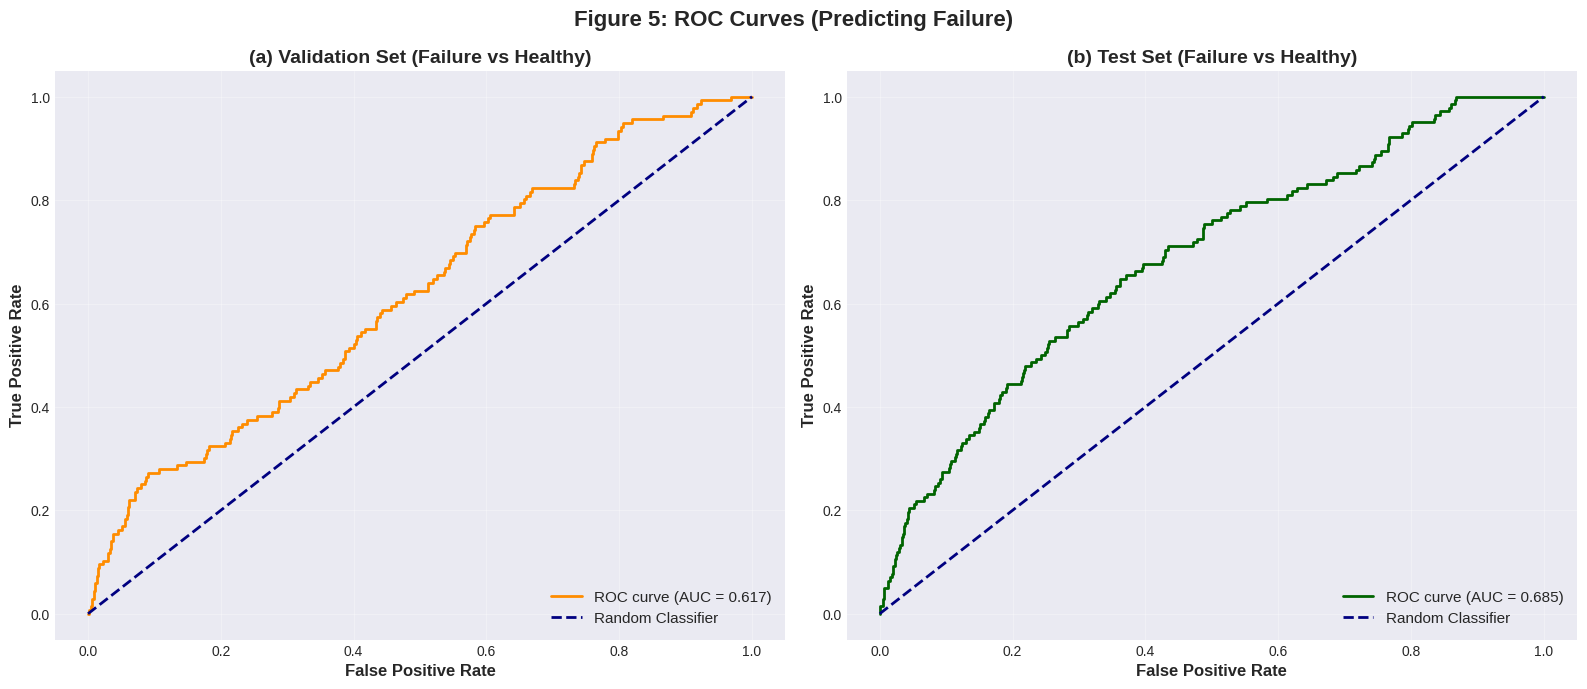


[6/10] Creating precision-recall curves...
✓ Saved: figure6_precision_recall_curves.png


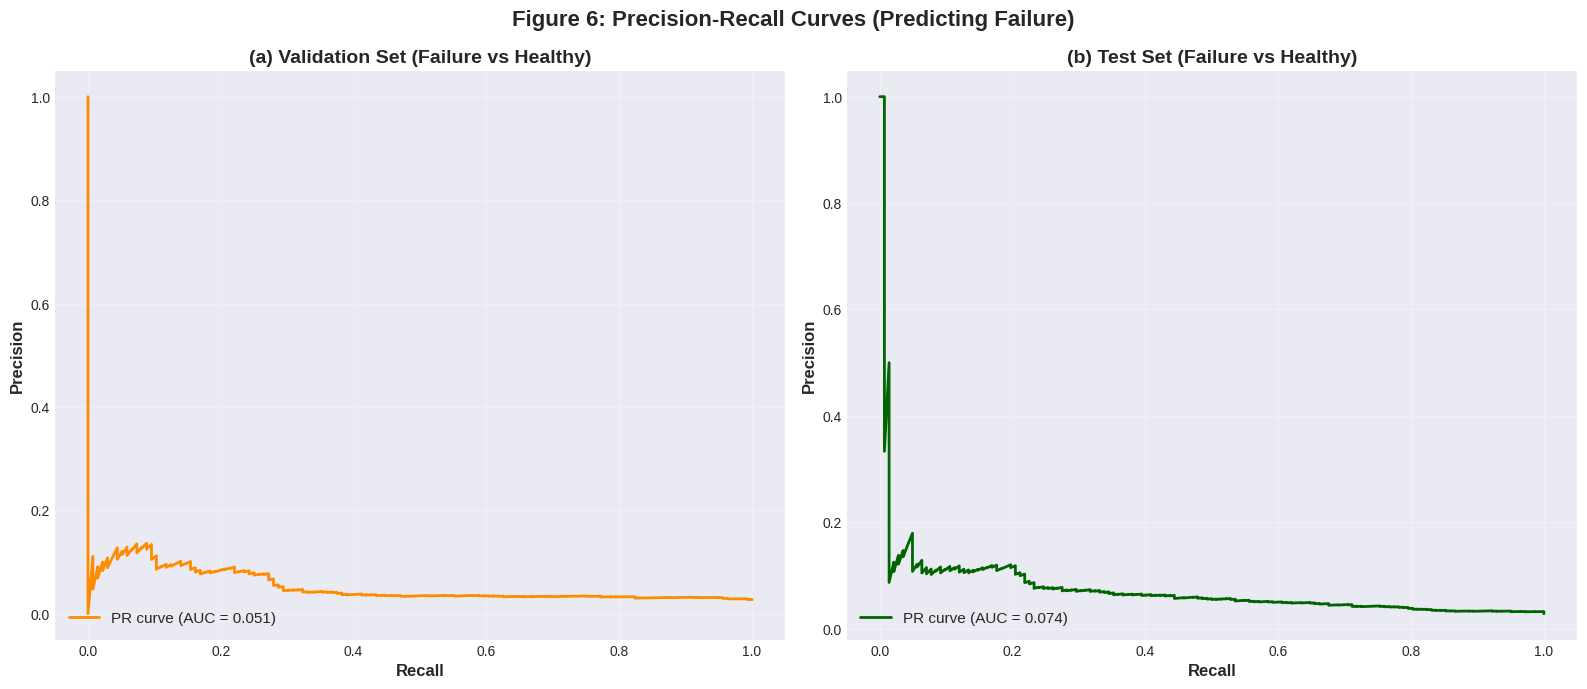


[7/10] Creating prediction confidence distribution...
✓ Saved: figure7_confidence_distribution.png


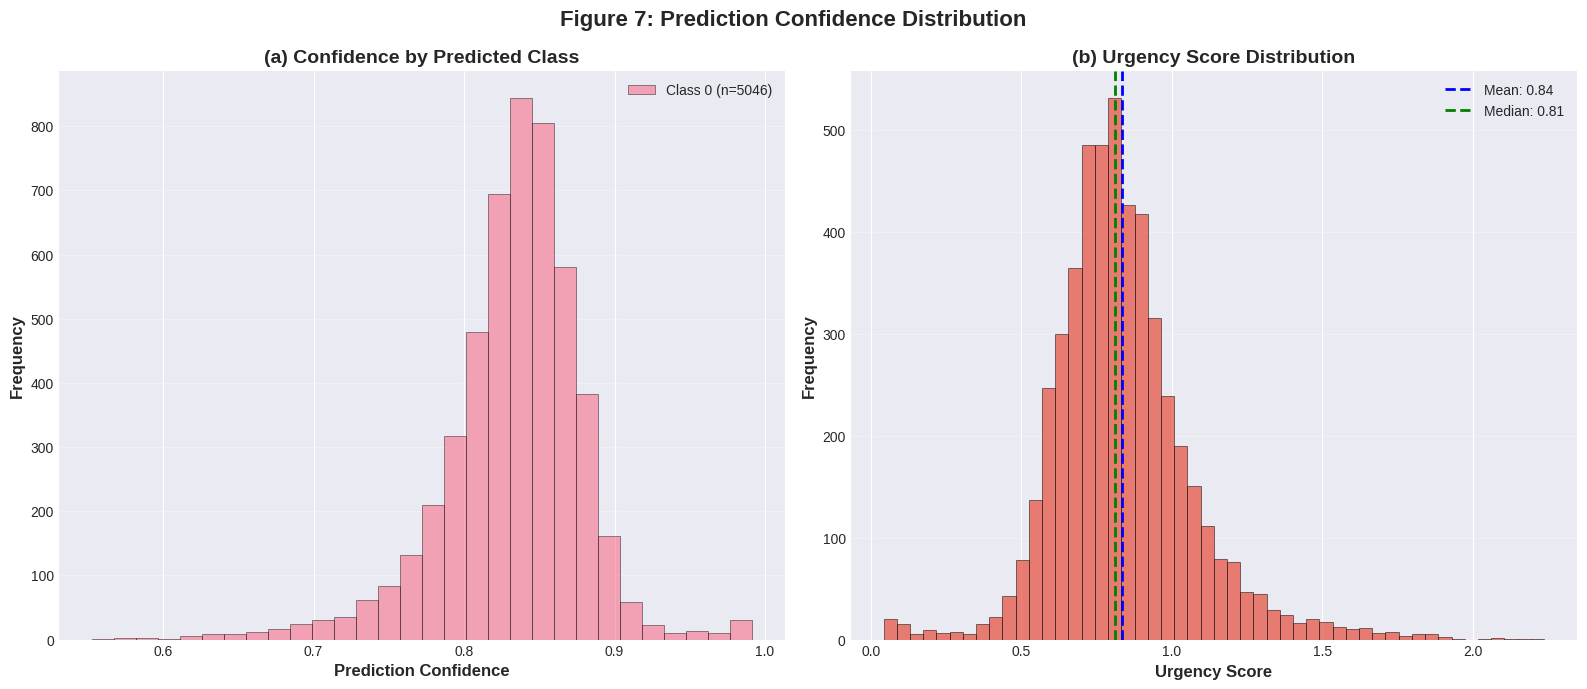


[8/10] Creating model comparison...
✓ Saved: figure8_model_comparison.png


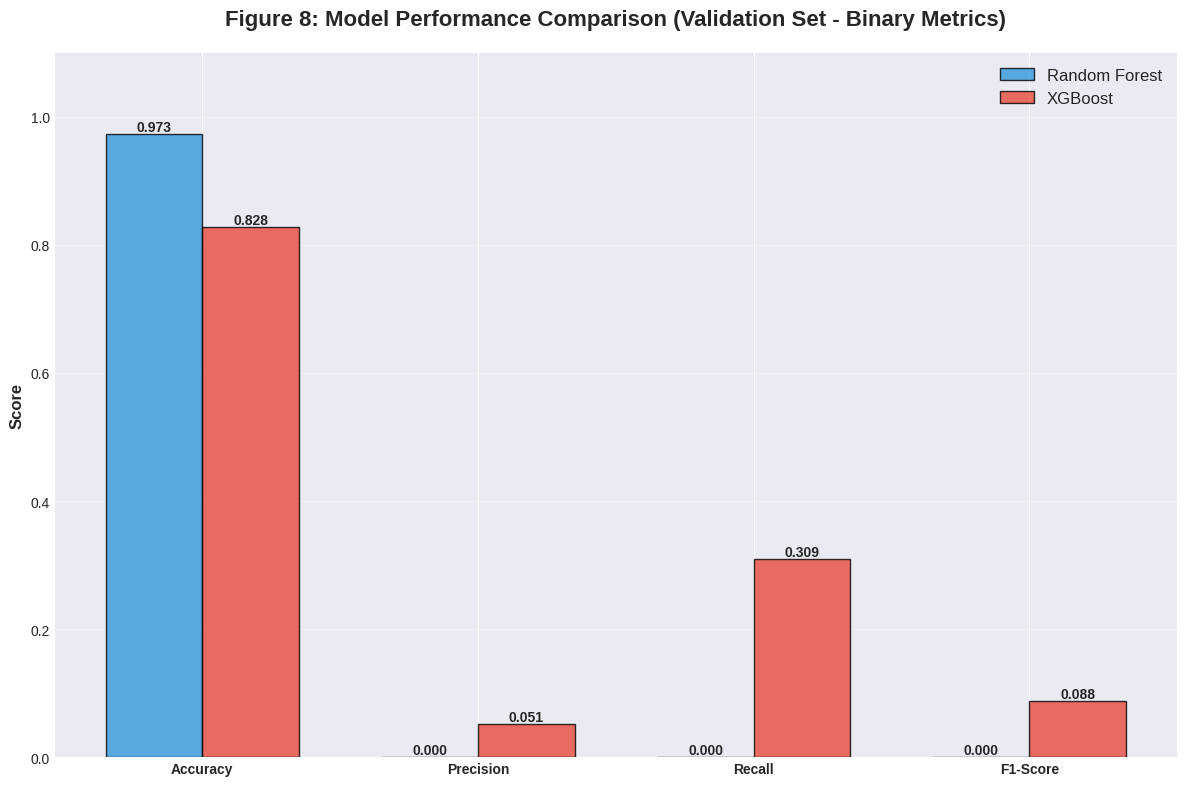


[9/10] Creating cost analysis visualization...
✓ Saved: figure9_cost_analysis.png


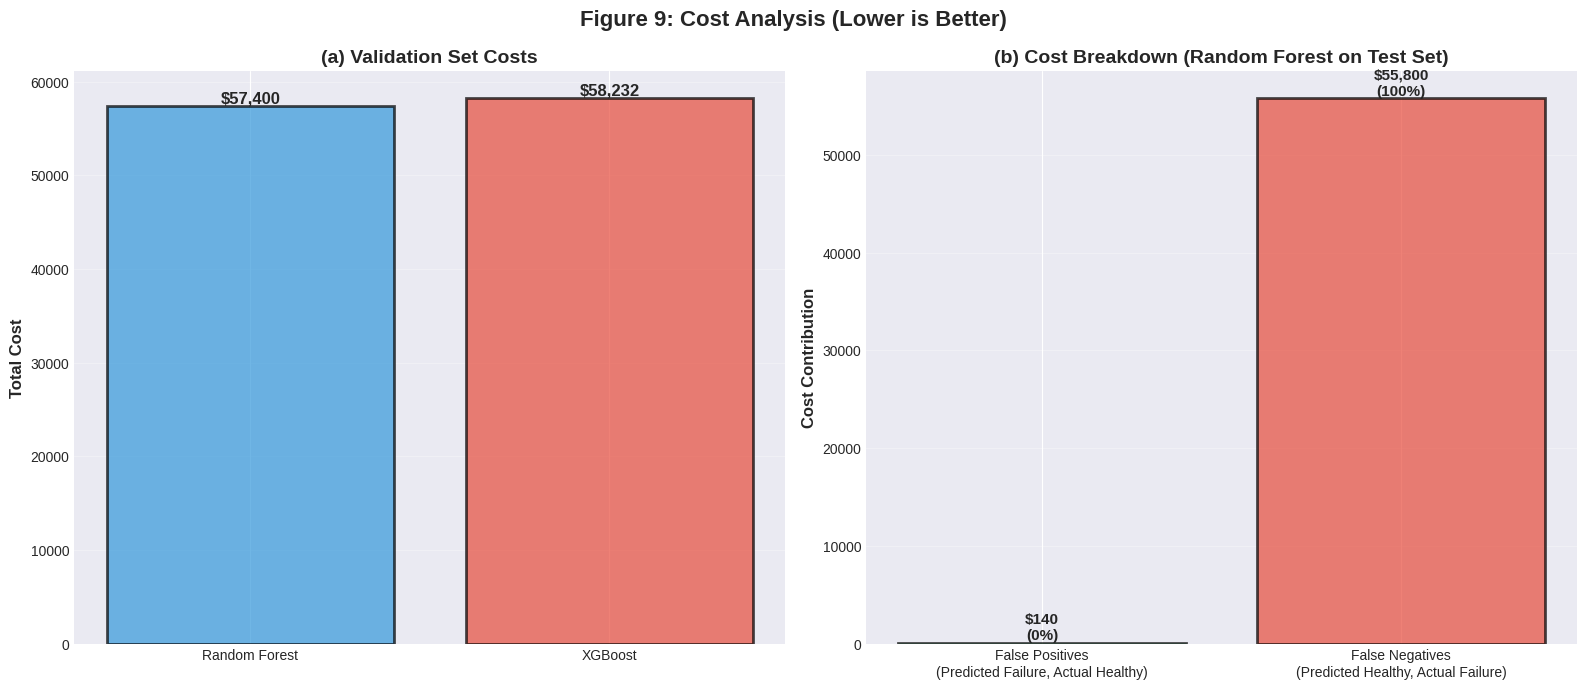


[10/10] Creating maintenance priority dashboard...
✓ Saved: figure10_maintenance_dashboard.png


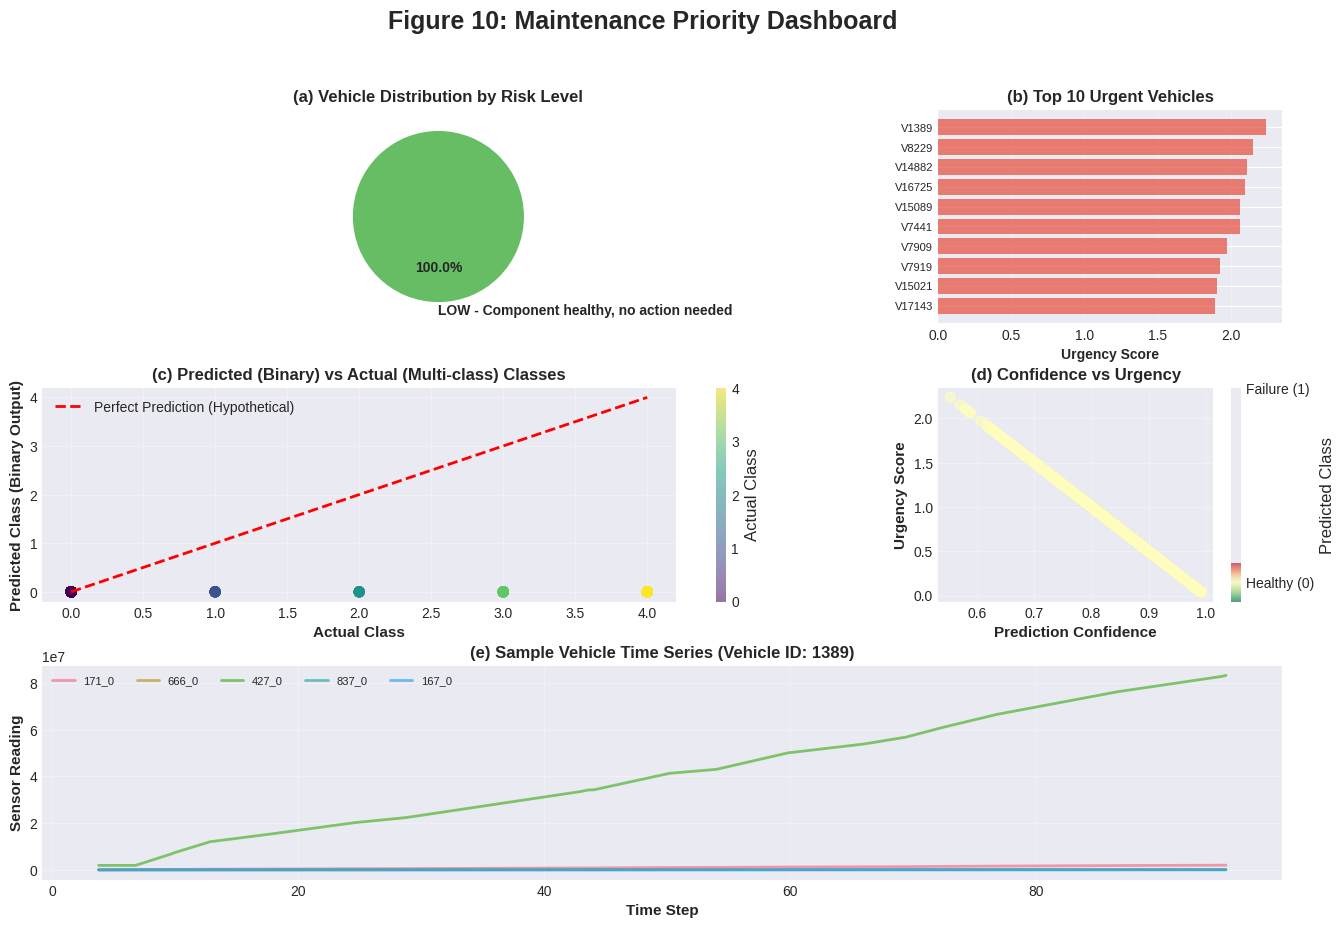


VISUALIZATION COMPLETE!

Generated figures:
  1. figure1_data_overview.png - Dataset statistics and distributions
  2. figure2_correlation_heatmap.png - Feature correlations
  3. figure3_feature_importance.png - Most important features
  4. figure4_confusion_matrices.png - Model performance matrices
  5. figure5_roc_curves.png - ROC curves (Predicting Failure)
  6. figure6_precision_recall_curves.png - Precision-Recall curves (Predicting Failure)
  7. figure7_confidence_distribution.png - Prediction confidence distribution
  8. figure8_model_comparison.png - Model performance comparison (Binary Metrics)
  9. figure9_cost_analysis.png - Cost analysis
  10. figure10_maintenance_dashboard.png - Maintenance priority dashboard


In [30]:
"""
Comprehensive Visualizations for Scania Predictive Maintenance Paper
Run this after your main pipeline and prediction system.
"""

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import warnings
warnings.filterwarnings('ignore')

# Set style for publication-quality plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

print("=" * 80)
print("CREATING VISUALIZATIONS FOR PAPER")
print("=" * 80)

# ============================================================================
# FIGURE 1: DATA OVERVIEW
# ============================================================================
print("\n[1/10] Creating data overview visualization...")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Figure 1: Dataset Overview', fontsize=16, fontweight='bold', y=0.995)

# 1a: Class distribution in training set
ax1 = axes[0, 0]
train_class_counts = train_data.groupby('vehicle_id')['in_study_repair'].first().value_counts()
colors = ['#2ecc71', '#e74c3c']
bars = ax1.bar(['Healthy (0)', 'Failed (1)'], train_class_counts.values, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Number of Vehicles', fontweight='bold')
ax1.set_title('(a) Training Set Class Distribution', fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}\n({height/train_class_counts.sum()*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold')

# 1b: Class distribution in validation set
ax2 = axes[0, 1]
val_class_counts = validation_data.groupby('vehicle_id')['class_label'].first().value_counts().sort_index()
colors_val = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(val_class_counts)))
bars = ax2.bar([f'Class {i}' for i in val_class_counts.index], val_class_counts.values,
               color=colors_val, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Number of Vehicles', fontweight='bold')
ax2.set_title('(b) Validation Set Class Distribution', fontweight='bold')
ax2.set_xlabel('Time Window Before Failure', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontweight='bold', fontsize=9)

# 1c: Time steps distribution
ax3 = axes[1, 0]
time_steps_per_vehicle = train_data.groupby('vehicle_id')['time_step'].max()
ax3.hist(time_steps_per_vehicle, bins=50, color='#3498db', alpha=0.7, edgecolor='black')
ax3.axvline(time_steps_per_vehicle.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {time_steps_per_vehicle.mean():.0f}')
ax3.axvline(time_steps_per_vehicle.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {time_steps_per_vehicle.median():.0f}')
ax3.set_xlabel('Maximum Time Step', fontweight='bold')
ax3.set_ylabel('Number of Vehicles', fontweight='bold')
ax3.set_title('(c) Vehicle Operation Duration Distribution', fontweight='bold')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 1d: Observations per vehicle
ax4 = axes[1, 1]
obs_per_vehicle = train_data.groupby('vehicle_id').size()
ax4.hist(obs_per_vehicle, bins=50, color='#9b59b6', alpha=0.7, edgecolor='black')
ax4.axvline(obs_per_vehicle.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {obs_per_vehicle.mean():.1f}')
ax4.axvline(obs_per_vehicle.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {obs_per_vehicle.median():.0f}')
ax4.set_xlabel('Number of Observations', fontweight='bold')
ax4.set_ylabel('Number of Vehicles', fontweight='bold')
ax4.set_title('(d) Observations Per Vehicle Distribution', fontweight='bold')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('figure1_data_overview.png', dpi=300, bbox_inches='tight')
print("✓ Saved: figure1_data_overview.png")
plt.show()

# ============================================================================
# FIGURE 2: FEATURE CORRELATION HEATMAP
# ============================================================================
print("\n[2/10] Creating feature correlation heatmap...")

# Select top features from aggregated data for correlation analysis
numeric_cols = X_train_agg.select_dtypes(include=[np.number]).columns[:30]  # Top 30 features
correlation_matrix = X_train_agg[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, ax=ax)
ax.set_title('Figure 2: Feature Correlation Heatmap (Top 30 Features)',
             fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('figure2_correlation_heatmap.png', dpi=300, bbox_inches='tight')
print("✓ Saved: figure2_correlation_heatmap.png")
plt.show()

# ============================================================================
# FIGURE 3: FEATURE IMPORTANCE
# ============================================================================
print("\n[3/10] Creating feature importance plot...")

# Get feature importance from best model
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
else:
    print("⚠ Model doesn't have feature_importances_, skipping this plot")
    importances = None

if importances is not None:
    # Create feature importance dataframe
    feature_importance_df = pd.DataFrame({
        'feature': X_train_agg.columns,
        'importance': importances
    }).sort_values('importance', ascending=False).head(20)

    fig, ax = plt.subplots(figsize=(12, 10))
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(feature_importance_df)))
    bars = ax.barh(range(len(feature_importance_df)), feature_importance_df['importance'],
                   color=colors, edgecolor='black', linewidth=0.5)
    ax.set_yticks(range(len(feature_importance_df)))
    ax.set_yticklabels(feature_importance_df['feature'], fontsize=9)
    ax.set_xlabel('Importance Score', fontweight='bold', fontsize=12)
    ax.set_title('Figure 3: Top 20 Most Important Features',
                 fontsize=16, fontweight='bold', pad=20)
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)

    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, feature_importance_df['importance'])):
        ax.text(val, i, f' {val:.4f}', va='center', fontsize=8)

    plt.tight_layout()
    plt.savefig('figure3_feature_importance.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: figure3_feature_importance.png")
    plt.show()

# ============================================================================
# FIGURE 4: CONFUSION MATRICES
# ============================================================================
print("\n[4/10] Creating confusion matrices...")

fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Figure 4: Model Performance - Confusion Matrices',
             fontsize=16, fontweight='bold', y=0.98)

# Validation confusion matrix
cm_val = confusion_matrix(y_val_agg, best_model.predict(X_val_scaled))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            cbar_kws={'label': 'Count'}, square=True, linewidths=1, linecolor='black')
axes[0].set_xlabel('Predicted Label', fontweight='bold', fontsize=12)
axes[0].set_ylabel('True Label', fontweight='bold', fontsize=12)
axes[0].set_title('(a) Validation Set', fontweight='bold', fontsize=14)

# Test confusion matrix
cm_test = confusion_matrix(y_test_agg, best_model.predict(X_test_scaled))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            cbar_kws={'label': 'Count'}, square=True, linewidths=1, linecolor='black')
axes[1].set_xlabel('Predicted Label', fontweight='bold', fontsize=12)
axes[1].set_ylabel('True Label', fontweight='bold', fontsize=12)
axes[1].set_title('(b) Test Set', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.savefig('figure4_confusion_matrices.png', dpi=300, bbox_inches='tight')
print("✓ Saved: figure4_confusion_matrices.png")
plt.show()

# ============================================================================
# FIGURE 5: ROC CURVES (for binary classification)
# ============================================================================
print("\n[5/10] Creating ROC curves...")

# Get prediction probabilities
y_val_proba = best_model.predict_proba(X_val_scaled)
y_test_proba = best_model.predict_proba(X_test_scaled)

# Determine if the model is binary or multi-class based on training data
# The model was trained on binary data (0 or 1), so its output probabilities will be for these two classes.
# We evaluate against the multi-class validation labels, but the model output is binary.
# To plot ROC, we'll treat the problem as predicting the 'positive' class (1) vs all others.
# We need to map the multi-class validation labels to binary for the ROC curve.
y_val_binary = (y_val_agg > 0).astype(int) # Map any non-zero label to 1 (failure)
y_test_binary = (y_test_agg > 0).astype(int) # Map any non-zero label to 1 (failure)


fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Figure 5: ROC Curves (Predicting Failure)',
             fontsize=16, fontweight='bold', y=0.98)

# Validation ROC
# Use the probability of the positive class (class 1)
if y_val_proba.shape[1] > 1: # Check if model provides probabilities for more than one class
    fpr_val, tpr_val, _ = roc_curve(y_val_binary, y_val_proba[:, 1])
    roc_auc_val = auc(fpr_val, tpr_val)

    axes[0].plot(fpr_val, tpr_val, color='darkorange', lw=2,
                 label=f'ROC curve (AUC = {roc_auc_val:.3f})')
    axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    axes[0].set_xlabel('False Positive Rate', fontweight='bold', fontsize=12)
    axes[0].set_ylabel('True Positive Rate', fontweight='bold', fontsize=12)
    axes[0].set_title('(a) Validation Set (Failure vs Healthy)', fontweight='bold', fontsize=14)
    axes[0].legend(loc="lower right", fontsize=11)
    axes[0].grid(alpha=0.3)
else:
    print("⚠ Model output is not probabilistic for validation set, skipping Validation ROC curve")


# Test ROC
# Use the probability of the positive class (class 1)
if y_test_proba.shape[1] > 1: # Check if model provides probabilities for more than one class
    fpr_test, tpr_test, _ = roc_curve(y_test_binary, y_test_proba[:, 1])
    roc_auc_test = auc(fpr_test, tpr_test)

    axes[1].plot(fpr_test, tpr_test, color='darkgreen', lw=2,
                 label=f'ROC curve (AUC = {roc_auc_test:.3f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    axes[1].set_xlabel('False Positive Rate', fontweight='bold', fontsize=12)
    axes[1].set_ylabel('True Positive Rate', fontweight='bold', fontsize=12)
    axes[1].set_title('(b) Test Set (Failure vs Healthy)', fontweight='bold', fontsize=14)
    axes[1].legend(loc="lower right", fontsize=11)
    axes[1].grid(alpha=0.3)
else:
     print("⚠ Model output is not probabilistic for test set, skipping Test ROC curve")

plt.tight_layout()
plt.savefig('figure5_roc_curves.png', dpi=300, bbox_inches='tight')
print("✓ Saved: figure5_roc_curves.png")
plt.show()

# ============================================================================
# FIGURE 6: PRECISION-RECALL CURVES
# ============================================================================
print("\n[6/10] Creating precision-recall curves...")

# Precision-Recall curves are also typically for binary classification.
# We will use the same binary mapping as for ROC curves.

fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Figure 6: Precision-Recall Curves (Predicting Failure)',
             fontsize=16, fontweight='bold', y=0.98)

# Validation PR curve
if y_val_proba.shape[1] > 1:
    precision_val, recall_val, _ = precision_recall_curve(y_val_binary, y_val_proba[:, 1])
    pr_auc_val = auc(recall_val, precision_val)

    axes[0].plot(recall_val, precision_val, color='darkorange', lw=2,
                 label=f'PR curve (AUC = {pr_auc_val:.3f})')
    axes[0].set_xlabel('Recall', fontweight='bold', fontsize=12)
    axes[0].set_ylabel('Precision', fontweight='bold', fontsize=12)
    axes[0].set_title('(a) Validation Set (Failure vs Healthy)', fontweight='bold', fontsize=14)
    axes[0].legend(loc="lower left", fontsize=11)
    axes[0].grid(alpha=0.3)
else:
     print("⚠ Model output is not probabilistic for validation set, skipping Validation PR curve")

# Test PR curve
if y_test_proba.shape[1] > 1:
    precision_test, recall_test, _ = precision_recall_curve(y_test_binary, y_test_proba[:, 1])
    pr_auc_test = auc(recall_test, precision_test)

    axes[1].plot(recall_test, precision_test, color='darkgreen', lw=2,
                 label=f'PR curve (AUC = {pr_auc_test:.3f})')
    axes[1].set_xlabel('Recall', fontweight='bold', fontsize=12)
    axes[1].set_ylabel('Precision', fontweight='bold', fontsize=12)
    axes[1].set_title('(b) Test Set (Failure vs Healthy)', fontweight='bold', fontsize=14)
    axes[1].legend(loc="lower left", fontsize=11)
    axes[1].grid(alpha=0.3)
else:
    print("⚠ Model output is not probabilistic for test set, skipping Test PR curve")

plt.tight_layout()
plt.savefig('figure6_precision_recall_curves.png', dpi=300, bbox_inches='tight')
print("✓ Saved: figure6_precision_recall_curves.png")
plt.show()

# ============================================================================
# FIGURE 7: PREDICTION CONFIDENCE DISTRIBUTION
# ============================================================================
print("\n[7/10] Creating prediction confidence distribution...")

fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Figure 7: Prediction Confidence Distribution',
             fontsize=16, fontweight='bold', y=0.98)

# Validation confidence by class
ax1 = axes[0]
for class_val in sorted(validation_predictions['predicted_class'].unique()):
    class_data = validation_predictions[validation_predictions['predicted_class'] == class_val]
    ax1.hist(class_data['prediction_confidence'], bins=30, alpha=0.6,
             label=f'Class {class_val} (n={len(class_data)})', edgecolor='black', linewidth=0.5)

ax1.set_xlabel('Prediction Confidence', fontweight='bold', fontsize=12)
ax1.set_ylabel('Frequency', fontweight='bold', fontsize=12)
ax1.set_title('(a) Confidence by Predicted Class', fontweight='bold', fontsize=14)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Urgency score distribution
ax2 = axes[1]
ax2.hist(validation_predictions['urgency_score'], bins=50, color='#e74c3c',
         alpha=0.7, edgecolor='black', linewidth=0.5)
ax2.axvline(validation_predictions['urgency_score'].mean(), color='blue',
            linestyle='--', linewidth=2, label=f"Mean: {validation_predictions['urgency_score'].mean():.2f}")
ax2.axvline(validation_predictions['urgency_score'].median(), color='green',
            linestyle='--', linewidth=2, label=f"Median: {validation_predictions['urgency_score'].median():.2f}")
ax2.set_xlabel('Urgency Score', fontweight='bold', fontsize=12)
ax2.set_ylabel('Frequency', fontweight='bold', fontsize=12)
ax2.set_title('(b) Urgency Score Distribution', fontweight='bold', fontsize=14)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('figure7_confidence_distribution.png', dpi=300, bbox_inches='tight')
print("✓ Saved: figure7_confidence_distribution.png")
plt.show()

# ============================================================================
# FIGURE 8: MODEL COMPARISON
# ============================================================================
print("\n[8/10] Creating model comparison...")

# Calculate metrics for both models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(y_true, y_pred, average='binary'):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average=average, zero_division=0),
        'Recall': recall_score(y_true, y_pred, average=average, zero_division=0),
        'F1-Score': f1_score(y_true, y_pred, average=average, zero_division=0)
    }

# Use the binary validation labels for metric calculation consistency with model output
y_val_binary_for_metrics = (y_val_agg > 0).astype(int)
y_test_binary_for_metrics = (y_test_agg > 0).astype(int)

# Predict on validation set for both models
val_pred_rf = rf_model.predict(X_val_scaled)
val_pred_xgb = xgb_model.predict(X_val_scaled)

# Calculate metrics using the binary validation labels
avg_type = 'binary'

rf_val_metrics = calculate_metrics(y_val_binary_for_metrics, val_pred_rf, avg_type)
xgb_val_metrics = calculate_metrics(y_val_binary_for_metrics, val_pred_xgb, avg_type)

metrics_df = pd.DataFrame({
    'Random Forest': rf_val_metrics,
    'XGBoost': xgb_val_metrics
})

fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(metrics_df))
width = 0.35

bars1 = ax.bar(x - width/2, metrics_df['Random Forest'], width,
               label='Random Forest', color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, metrics_df['XGBoost'], width,
               label='XGBoost', color='#e74c3c', alpha=0.8, edgecolor='black')

ax.set_ylabel('Score', fontweight='bold', fontsize=12)
ax.set_title('Figure 8: Model Performance Comparison (Validation Set - Binary Metrics)',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(metrics_df.index, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.1])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('figure8_model_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Saved: figure8_model_comparison.png")
plt.show()

# ============================================================================
# FIGURE 9: COST ANALYSIS
# ============================================================================
print("\n[9/10] Creating cost analysis visualization...")

# Calculate costs for both models
# Use the original multi-class y_val_agg and y_test_agg for cost calculation
rf_cost_val = calculate_cost(y_val_agg, val_pred_rf)
xgb_cost_val = calculate_cost(y_val_agg, val_pred_xgb)
# Make sure to use the predictions from the best model on the test set
best_model_test_pred = best_model.predict(X_test_scaled)
best_model_cost_test = calculate_cost(y_test_agg, best_model_test_pred)


fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Figure 9: Cost Analysis (Lower is Better)',
             fontsize=16, fontweight='bold', y=0.98)

# Validation costs
ax1 = axes[0]
costs_val = [rf_cost_val, xgb_cost_val]
models = ['Random Forest', 'XGBoost']
colors = ['#3498db', '#e74c3c']
bars = ax1.bar(models, costs_val, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_ylabel('Total Cost', fontweight='bold', fontsize=12)
ax1.set_title('(a) Validation Set Costs', fontweight='bold', fontsize=14)
ax1.grid(axis='y', alpha=0.3)

for bar, cost in zip(bars, costs_val):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'${cost:,.0f}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

# Cost breakdown by error type (using the best model on test set for breakdown example)
ax2 = axes[1]

# Calculate breakdown for the best model on the test set
cm_test_best = confusion_matrix(y_test_agg, best_model_test_pred)

# Cost matrix simplified for visualization
cost_matrix_viz = {
    (0, 1): 7, (0, 2): 8, (0, 3): 9, (0, 4): 10,
    (1, 0): 200, (1, 2): 7, (1, 3): 8, (1, 4): 9,
    (2, 0): 300, (2, 1): 200, (2, 3): 7, (2, 4): 8,
    (3, 0): 400, (3, 1): 300, (3, 2): 200, (3, 4): 7,
    (4, 0): 500, (4, 1): 400, (4, 2): 300, (4, 3): 200
}

false_positive_cost = 0
false_negative_cost = 0
for i in range(cm_test_best.shape[0]):
    for j in range(cm_test_best.shape[1]):
        if i != j:
            error_count = cm_test_best[i, j]
            error_cost_per_instance = cost_matrix_viz.get((i, j), 0)
            total_error_cost = error_count * error_cost_per_instance

            # Classify as FP or FN for this simplified view
            # If true label is 0 (healthy) and predicted is > 0 (failure class), it's a type of FP
            if i == 0 and j > 0:
                 false_positive_cost += total_error_cost
            # If true label is > 0 (failure class) and predicted is 0 (healthy), it's a type of FN
            elif i > 0 and j == 0:
                 false_negative_cost += total_error_cost
            # Other misclassifications contribute to both FP/FN conceptually, but for
            # this simple breakdown, we'll group them based on whether the true class
            # was 'healthy' (0) or 'failure' (>0).
            elif i > 0 and j > 0:
                 # If true class is failure (>0) and predicted is also failure (>0) but wrong class
                 # This contributes to the cost of misclassifying a failure, closer to FN cost impact.
                 false_negative_cost += total_error_cost
            elif i == 0 and j == 0:
                 # Correctly predicted healthy, no cost
                 pass


error_types = ['False Positives\n(Predicted Failure, Actual Healthy)',
               'False Negatives\n(Predicted Healthy, Actual Failure)']
costs_breakdown = [false_positive_cost, false_negative_cost]
colors_breakdown = ['#2ecc71', '#e74c3c']

# Handle case where both costs are zero (perfect prediction or no relevant errors)
if sum(costs_breakdown) == 0:
     error_types = ['No Errors']
     costs_breakdown = [0]
     colors_breakdown = ['#cccccc']


bars = ax2.bar(error_types, costs_breakdown, color=colors_breakdown, alpha=0.7,
               edgecolor='black', linewidth=2)
ax2.set_ylabel('Cost Contribution', fontweight='bold', fontsize=12)
ax2.set_title(f'(b) Cost Breakdown ({best_model_name} on Test Set)', fontweight='bold', fontsize=14)
ax2.grid(axis='y', alpha=0.3)

for bar, cost in zip(bars, costs_breakdown):
    height = bar.get_height()
    if height > 0:
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                 f'${cost:,.0f}\n({cost/sum(costs_breakdown)*100:.0f}%)',
                 ha='center', va='bottom', fontsize=11, fontweight='bold')
    elif len(costs_breakdown) == 1 and costs_breakdown[0] == 0:
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                 '$0',
                 ha='center', va='bottom', fontsize=12, fontweight='bold')


plt.tight_layout()
plt.savefig('figure9_cost_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Saved: figure9_cost_analysis.png")
plt.show()

# ============================================================================
# FIGURE 10: MAINTENANCE PRIORITY DASHBOARD
# ============================================================================
print("\n[10/10] Creating maintenance priority dashboard...")

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

fig.suptitle('Figure 10: Maintenance Priority Dashboard',
             fontsize=18, fontweight='bold', y=0.98)

# 10a: Risk level pie chart
ax1 = fig.add_subplot(gs[0, :2])
risk_counts = validation_predictions['risk_level'].value_counts()
colors_risk = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(risk_counts)))
wedges, texts, autotexts = ax1.pie(risk_counts.values, labels=risk_counts.index,
                                     autopct='%1.1f%%', colors=colors_risk,
                                     startangle=90, textprops={'fontsize': 10, 'fontweight': 'bold'})
ax1.set_title('(a) Vehicle Distribution by Risk Level', fontweight='bold', fontsize=12)

# 10b: Top vehicles needing attention
ax2 = fig.add_subplot(gs[0, 2])
top_urgent = validation_predictions.nlargest(10, 'urgency_score')
ax2.barh(range(len(top_urgent)), top_urgent['urgency_score'], color='#e74c3c', alpha=0.7)
ax2.set_yticks(range(len(top_urgent)))
ax2.set_yticklabels([f"V{int(vid)}" for vid in top_urgent['vehicle_id']], fontsize=8)
ax2.set_xlabel('Urgency Score', fontsize=10, fontweight='bold')
ax2.set_title('(b) Top 10 Urgent Vehicles', fontweight='bold', fontsize=12)
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

# 10c: Predicted vs Actual (validation)
ax3 = fig.add_subplot(gs[1, :2])
pred_vs_actual = pd.DataFrame({
    'Actual': y_val_agg,
    'Predicted': best_model.predict(X_val_scaled)
})
# Map predicted binary output (0 or 1) to match potential multi-class actuals for scatter color
# This is a simplification for visualization; the model only predicts 0 or 1.
pred_vs_actual['Predicted_Mapped'] = pred_vs_actual['Predicted']
scatter = ax3.scatter(pred_vs_actual['Actual'], pred_vs_actual['Predicted_Mapped'],
                     alpha=0.5, c=pred_vs_actual['Actual'], cmap='viridis', s=50)
ax3.plot([pred_vs_actual['Actual'].min(), pred_vs_actual['Actual'].max()],
         [pred_vs_actual['Actual'].min(), pred_vs_actual['Actual'].max()],
         'r--', lw=2, label='Perfect Prediction (Hypothetical)') # Adjusted label
ax3.set_xlabel('Actual Class', fontweight='bold', fontsize=11)
ax3.set_ylabel('Predicted Class (Binary Output)', fontweight='bold', fontsize=11) # Adjusted label
ax3.set_title('(c) Predicted (Binary) vs Actual (Multi-class) Classes', fontweight='bold', fontsize=12) # Adjusted title
ax3.legend()
ax3.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax3, label='Actual Class')

# 10d: Confidence vs Urgency
ax4 = fig.add_subplot(gs[1, 2])
scatter = ax4.scatter(validation_predictions['prediction_confidence'],
                     validation_predictions['urgency_score'],
                     c=validation_predictions['predicted_class'], # Use binary predicted class for color
                     cmap='RdYlGn_r', alpha=0.6, s=50)
ax4.set_xlabel('Prediction Confidence', fontweight='bold', fontsize=11)
ax4.set_ylabel('Urgency Score', fontweight='bold', fontsize=11)
ax4.set_title('(d) Confidence vs Urgency', fontweight='bold', fontsize=12)
ax4.grid(alpha=0.3)
# Colorbar legend for the binary predicted class
cbar = plt.colorbar(scatter, ax=ax4, label='Predicted Class')
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Healthy (0)', 'Failure (1)'])


# 10e: Time series of a sample vehicle
ax5 = fig.add_subplot(gs[2, :])
sample_vehicle = validation_predictions.iloc[0]['vehicle_id']
sample_data = validation_data[validation_data['vehicle_id'] == sample_vehicle].sort_values('time_step')
# Plot first 5 sensor columns
for i, col in enumerate(sensor_cols[:5]):
    ax5.plot(sample_data['time_step'], sample_data[col],
            label=col, alpha=0.7, linewidth=2)
ax5.set_xlabel('Time Step', fontweight='bold', fontsize=11)
ax5.set_ylabel('Sensor Reading', fontweight='bold', fontsize=11)
ax5.set_title(f'(e) Sample Vehicle Time Series (Vehicle ID: {int(sample_vehicle)})',
             fontweight='bold', fontsize=12)
ax5.legend(loc='upper left', fontsize=8, ncol=5)
ax5.grid(alpha=0.3)

plt.savefig('figure10_maintenance_dashboard.png', dpi=300, bbox_inches='tight')
print("✓ Saved: figure10_maintenance_dashboard.png")
plt.show()

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "=" * 80)
print("VISUALIZATION COMPLETE!")
print("=" * 80)
print("\nGenerated figures:")
print("  1. figure1_data_overview.png - Dataset statistics and distributions")
print("  2. figure2_correlation_heatmap.png - Feature correlations")
print("  3. figure3_feature_importance.png - Most important features")
print("  4. figure4_confusion_matrices.png - Model performance matrices")
print("  5. figure5_roc_curves.png - ROC curves (Predicting Failure)")
print("  6. figure6_precision_recall_curves.png - Precision-Recall curves (Predicting Failure)")
print("  7. figure7_confidence_distribution.png - Prediction confidence distribution")
print("  8. figure8_model_comparison.png - Model performance comparison (Binary Metrics)")
print("  9. figure9_cost_analysis.png - Cost analysis")
print("  10. figure10_maintenance_dashboard.png - Maintenance priority dashboard")